# Noise2Void Experiment

[CVPR 2019 : Noise2Void - Learning Denoising from Single Noisy Image](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)

Key idea: 
- Blind-spot network(BSN), network learn the mapping between mask pixel(s) and every other pixels
- the expect of output identical to clean image when noise mean is zero and i.i.d and there traing data inf.

Pros: 
1. single noisy image denoising, has tremendous practicality on medical denoising task
2. can adaptive to any noise distribution since its learn denoising directly from noisy image 

Cons:
1. by masking certain pixel(s), the quality of denoising decrease, especially for high-frequency content
2. strong assumption of zero mean noise and pixels i.i.d, leading to poor performance when it dealing with structured noise 
3. denoising performance slightly degrade to N2N but still better than BM3D

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import UNet2_5D
from module.datasets import MaskDataset


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4611089527606964); std:0.022531788796186447
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -23.428024291992188, 'noise_max': 28.14098358154297}


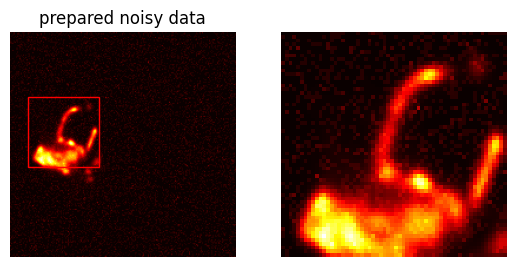

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poisson_0.35_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

## Process Denoising

## 1. import denoising network

In [3]:
model = UNet2_5D(in_channels=3, out_channels=1)
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
         LeakyReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
         LeakyReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
        LeakyReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

## 2. create mask dataset and dataloader

In [4]:
# def split_tensor(data_tensor):
#     """split tensor into train, test, vali tensor

#     Args:
#         data_tensor (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     test_tensor = data_tensor[0:1]
    
#     rest_tensor = data_tensor[1:]

#     total_samples = rest_tensor.shape[0]
    
#     train_ration = 0.8
#     train_length = int(train_ration * total_samples)
#     val_length = total_samples - train_length
    
    
#     train_subset, val_subset = random_split(rest_tensor, [train_length, val_length])
    
    
#     # Convert Subset back into tensors
#     train_tensor = train_subset.dataset[train_subset.indices]
#     val_tensor = val_subset.dataset[val_subset.indices]

#     return train_tensor, val_tensor, test_tensor


def split_data(data_array):
    """split ndarray into train, test, vali arrays

    Args:
        data_array (numpy.ndarray): The input data array.

    Returns:
        numpy.ndarray, numpy.ndarray, numpy.ndarray: Train, Validation, Test arrays.
    """
    test_array = data_array[0:1]
    rest_array = data_array[1:]

    total_samples = rest_array.shape[0]
    
    train_ration = 0.8
    train_length = int(train_ration * total_samples)
    val_length = total_samples - train_length
    
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_array = rest_array[indices[:train_length]]
    val_array = rest_array[indices[train_length:]]

    return train_array, val_array, test_array

In [5]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)


## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


## create dataset
num_mask = 1

train_dataset = MaskDataset(train_tensor, num_mask)
val_dataset = MaskDataset(val_tensor, num_mask)
test_dataset = MaskDataset(test_tensor, num_mask)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 32
num_workers = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,1.0); mean:0.4610922932624817; std:0.022525180131196976
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.0,0.9834094047546387); mean:0.4610878825187683; std:0.022528864443302155
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(1.3795903214486316e-05,0.9612170457839966); mean:0.46108314394950867; std:0.022591445595026016
train_dataset: 13248
val_dataset: 3312
test_dataset: 1656


Batch 1
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5484856367111206,0.4515281617641449); mean:0.45831188559532166; std:0.011475051753222942
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0581881999969482,0.4515281617641449); mean:0.4583243727684021; std:0.0118169654160738
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45830604434013367; std:0.011467368341982365
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5484856367111206,0.4515281617641449); mean:0.45830971002578735; std:0.011470472440123558


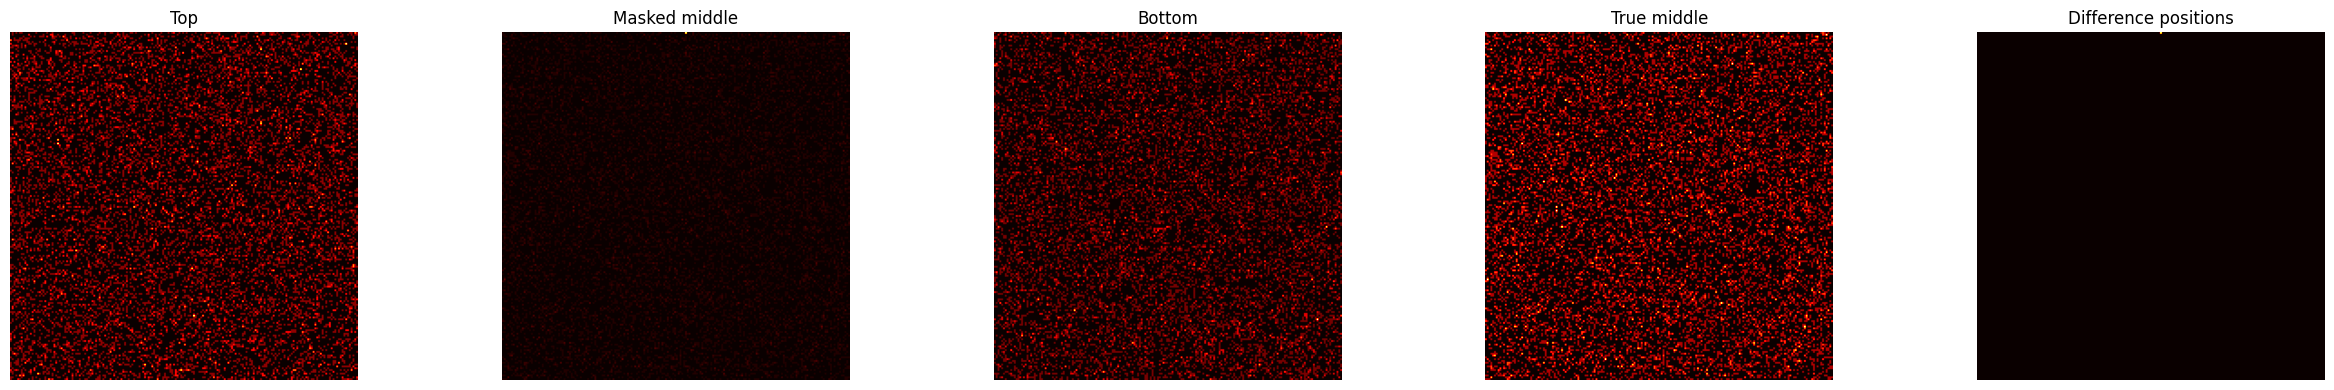

Batch 2
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45831483602523804; std:0.011464046314358711
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0387967824935913,0.4515281617641449); mean:0.4583299458026886; std:0.011806349270045757
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5484856367111206,0.4515281617641449); mean:0.4583240747451782; std:0.011471468955278397
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.4583151638507843; std:0.011464161798357964


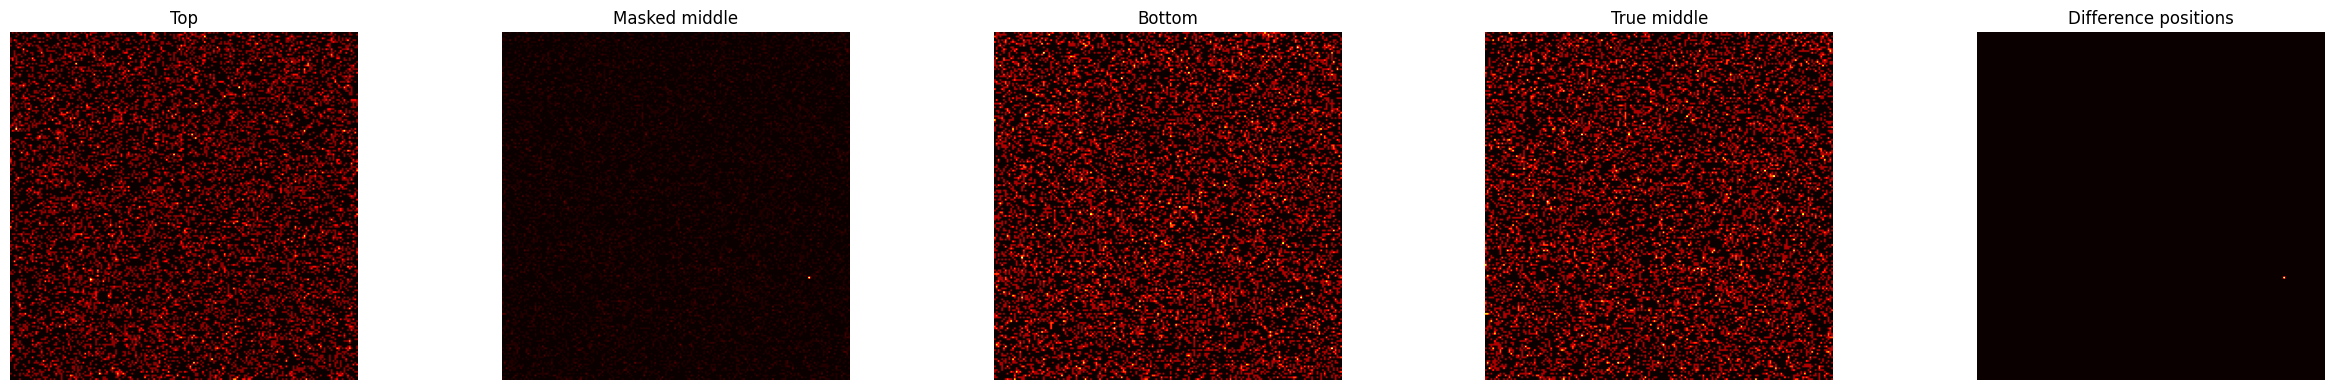

Batch 3
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.4583245813846588; std:0.011479189619421959
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0387967824935913,0.4515281617641449); mean:0.45833736658096313; std:0.01182478852570057
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45831844210624695; std:0.011486098170280457
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45832258462905884; std:0.011481622233986855


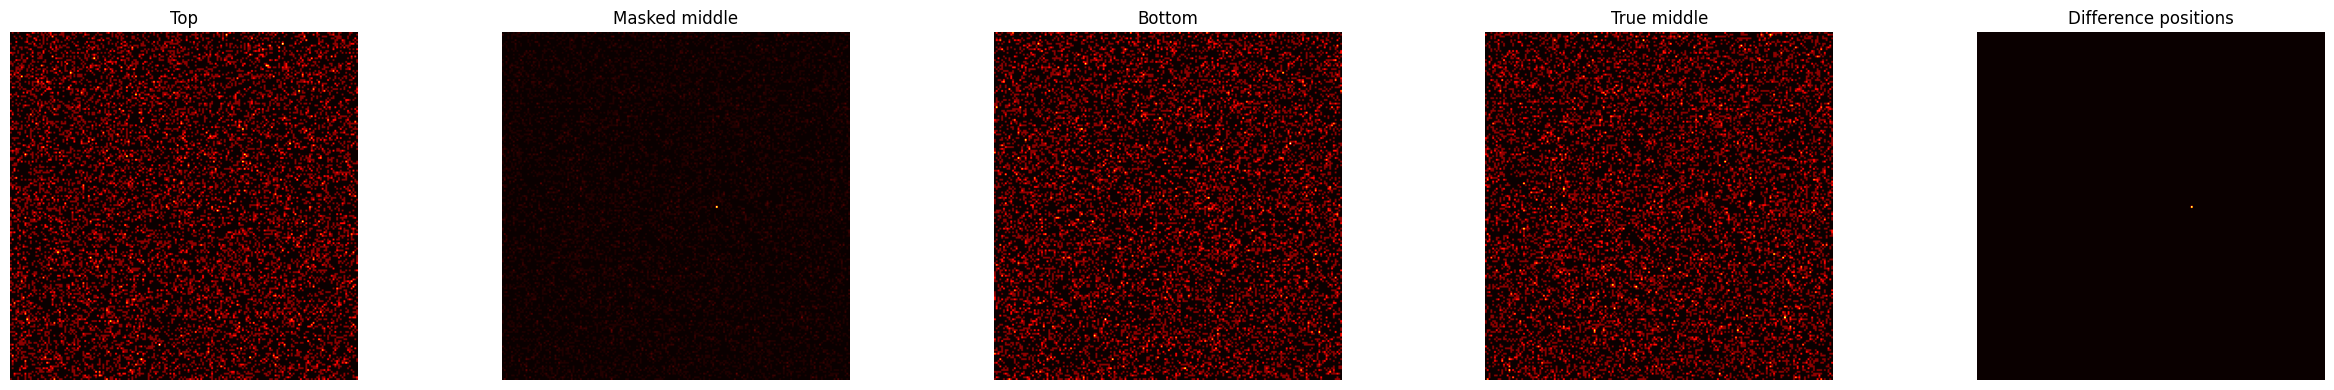

Batch 4
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.4583050012588501; std:0.01145374495536089
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0387967824935913,0.4515281617641449); mean:0.45832327008247375; std:0.011802693828940392
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45830705761909485; std:0.011451108381152153
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5678771138191223,0.4515281617641449); mean:0.45830848813056946; std:0.011454896070063114


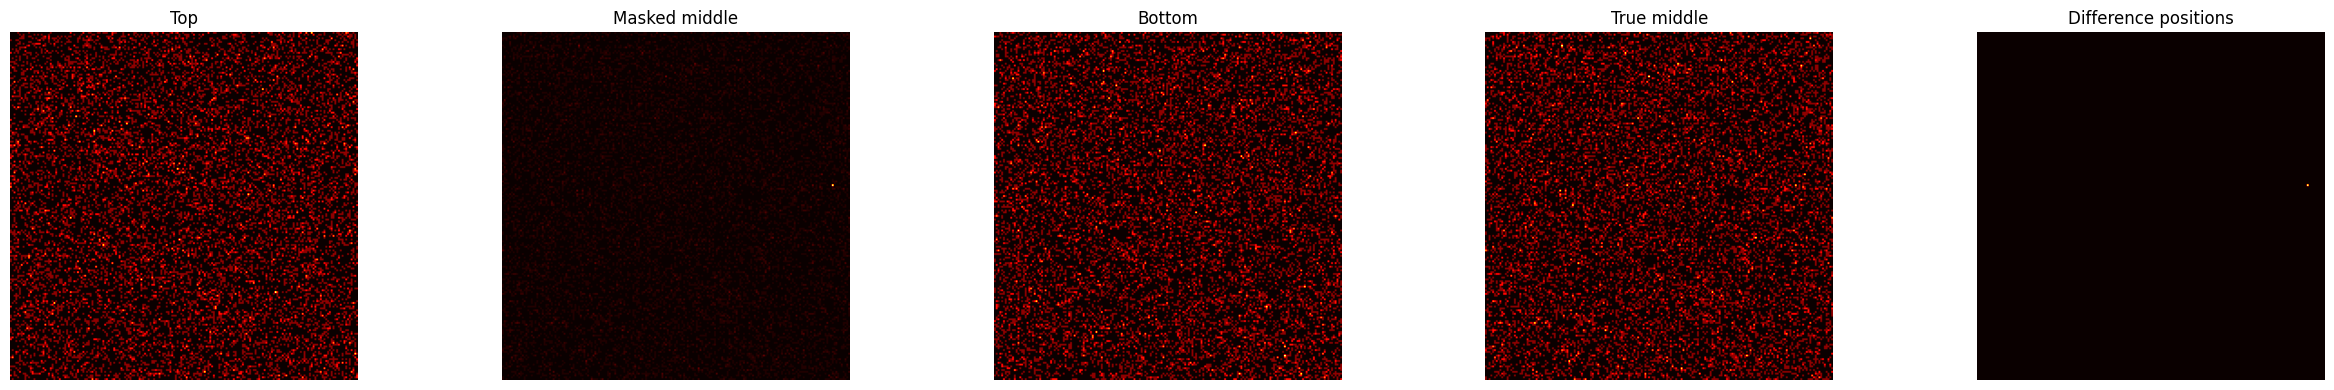

Batch 5
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9418255090713501,0.03307092562317848); mean:0.4582870900630951; std:0.014064698480069637
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.416052222251892,0.03307092562317848); mean:0.45830243825912476; std:0.01454778853803873
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9418255090713501,0.03307092562317848); mean:0.45829370617866516; std:0.014010434970259666
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9418255090713501,0.03307092562317848); mean:0.45828336477279663; std:0.014056268148124218


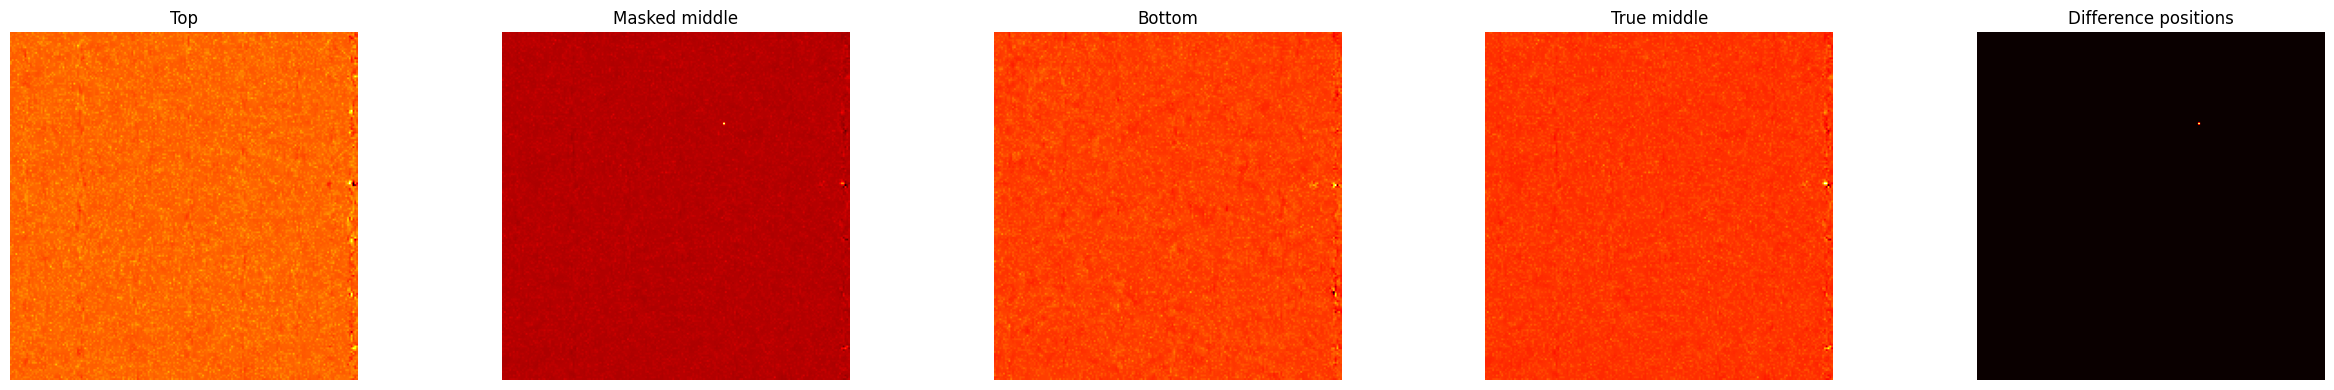

In [6]:
# example batch plot
num_batches_to_display = 5  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (top_slice, mask_middle_slice, bottom_slice, middle_slice) in enumerate(val_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
    print(f"mask_middle_slice: {mask_middle_slice.dtype} {mask_middle_slice.shape} range:({torch.max(mask_middle_slice)},{torch.min(mask_middle_slice)}); mean:{torch.mean(mask_middle_slice)}; std:{torch.std(mask_middle_slice)}")
    print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
    print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 5, figsize=(25, 4))

    axes[0].imshow(top_slice[idx].squeeze().numpy(), cmap='hot')
    axes[0].set_title('Top')

    axes[1].imshow(mask_middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[1].set_title('Masked middle')

    axes[2].imshow(bottom_slice[idx].squeeze().numpy(), cmap='hot')
    axes[2].set_title('Bottom')

    axes[3].imshow(middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[3].set_title('True middle')

    # Show difference
    difference = (mask_middle_slice[idx] != middle_slice[idx]).float().squeeze().numpy()

    canvas = np.zeros_like(difference)

    # Set the differing pixels to 1
    canvas[difference > 0] = 1

    axes[4].imshow(canvas, cmap='hot')
    axes[4].set_title('Difference positions')
    
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break


## 3.  define training modules 

In [7]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
        top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
        
        # Forward
        outputs = model(top_slice, mask_middle_slice, bottom_slice)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = criterion(outputs, middle_slice)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            outputs = model(top_slice, mask_middle_slice, bottom_slice)
            loss = criterion(outputs, middle_slice)
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss

# @timer_decorator
# def test(model, test_loader, device):
#     model.eval()
#     preds = []
#     targets = []
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
#             top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
#             pred = model(top_slice, mask_middle_slice, bottom_slice)
#             preds.append(pred.cpu()) # predict
#             targets.append(middle_slice.cpu()) # original input data
            
#     return preds, targets
# def test(model, test_loader, device, original_shape):
#     # 初始化两个全0的tensor用于存放预测和目标
#     preds = torch.zeros(original_shape).to(device)
#     targets = torch.zeros(original_shape).to(device)

#     model.eval()
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slices) in enumerate(pbar):
#             top_slice, mask_middle_slice, bottom_slice, middle_slices = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slices.to(device)
            
#             batch_preds = model(top_slice, mask_middle_slice, bottom_slice)
            
#             for b_idx, pred in enumerate(batch_preds):
#                 # 计算应该放置预测值和目标值的位置
#                 patience_idx = (idx * len(batch_preds) + b_idx) // (original_shape[1] * (original_shape[3] - 2))
#                 time_idx = ((idx * len(batch_preds) + b_idx) % (original_shape[1] * (original_shape[3] - 2))) // (original_shape[3] - 2)
#                 depth_idx = (idx * len(batch_preds) + b_idx) % (original_shape[3] - 2) + 1
                
#                 pred = pred.squeeze(0)
#                 middle_slice = middle_slices[b_idx].squeeze(0)
                
#                 preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
#                 targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice

#     return preds.cpu(), targets.cpu()

def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slice) in enumerate(pbar):
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
            batch_preds = model(top_slice, mask_middle_slice, bottom_slice)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1

                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice[b_idx]

    return preds.cpu(), targets.cpu()




@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement.(epoch {epoch - patience})")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## 4. process training

In [9]:
best_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.01532664, Validation Loss: 0.00432124, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/200, Train Loss: 0.00437686, Validation Loss: 0.00424066, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3/200, Train Loss: 0.00418957, Validation Loss: 0.00197828, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.00272746, Validation Loss: 0.00363635, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.00318488, Validation Loss: 0.00748021, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6/200, Train Loss: 0.00127617, Validation Loss: 0.00240531, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.00140694, Validation Loss: 0.00381291, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.00155745, Validation Loss: 0.00073598, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/200, Train Loss: 0.00207143, Validation Loss: 0.00072863, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.00157242, Validation Loss: 0.00480856, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 11/200, Train Loss: 0.00084241, Validation Loss: 0.00063610, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/200, Train Loss: 0.00072930, Validation Loss: 0.00163197, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 13/200, Train Loss: 0.00082461, Validation Loss: 0.00095971, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 14/200, Train Loss: 0.00088949, Validation Loss: 0.00122111, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/200, Train Loss: 0.00076798, Validation Loss: 0.00049515, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 16/200, Train Loss: 0.00049796, Validation Loss: 0.00039174, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 17/200, Train Loss: 0.00051822, Validation Loss: 0.00132086, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 18/200, Train Loss: 0.00051716, Validation Loss: 0.00038993, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 19/200, Train Loss: 0.00046163, Validation Loss: 0.00025752, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/200, Train Loss: 0.00039645, Validation Loss: 0.00028997, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 21/200, Train Loss: 0.00027541, Validation Loss: 0.00083473, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 22/200, Train Loss: 0.00026281, Validation Loss: 0.00041389, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 23/200, Train Loss: 0.00024604, Validation Loss: 0.00017628, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 24/200, Train Loss: 0.00025801, Validation Loss: 0.00027624, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/200, Train Loss: 0.00027108, Validation Loss: 0.00041401, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 26/200, Train Loss: 0.00020100, Validation Loss: 0.00020059, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 27/200, Train Loss: 0.00018638, Validation Loss: 0.00025865, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 28/200, Train Loss: 0.00019998, Validation Loss: 0.00019451, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 29/200, Train Loss: 0.00017934, Validation Loss: 0.00027259, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/200, Train Loss: 0.00018144, Validation Loss: 0.00022336, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 31/200, Train Loss: 0.00016513, Validation Loss: 0.00013403, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 32/200, Train Loss: 0.00016132, Validation Loss: 0.00022537, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 33/200, Train Loss: 0.00015967, Validation Loss: 0.00011817, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 34/200, Train Loss: 0.00015766, Validation Loss: 0.00024271, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 35/200, Train Loss: 0.00015488, Validation Loss: 0.00027329, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 36/200, Train Loss: 0.00014186, Validation Loss: 0.00012028, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 37/200, Train Loss: 0.00014083, Validation Loss: 0.00013969, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 38/200, Train Loss: 0.00013889, Validation Loss: 0.00011644, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 39/200, Train Loss: 0.00013745, Validation Loss: 0.00020985, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 40/200, Train Loss: 0.00014003, Validation Loss: 0.00013027, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 41/200, Train Loss: 0.00013132, Validation Loss: 0.00011056, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 42/200, Train Loss: 0.00013035, Validation Loss: 0.00011248, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 43/200, Train Loss: 0.00013065, Validation Loss: 0.00012621, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 44/200, Train Loss: 0.00013019, Validation Loss: 0.00012379, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 45/200, Train Loss: 0.00012687, Validation Loss: 0.00011729, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 46/200, Train Loss: 0.00012491, Validation Loss: 0.00013415, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 47/200, Train Loss: 0.00012421, Validation Loss: 0.00011106, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 48/200, Train Loss: 0.00012364, Validation Loss: 0.00013702, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 49/200, Train Loss: 0.00012549, Validation Loss: 0.00010905, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 50/200, Train Loss: 0.00012239, Validation Loss: 0.00010880, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 51/200, Train Loss: 0.00012222, Validation Loss: 0.00010951, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 52/200, Train Loss: 0.00012069, Validation Loss: 0.00011071, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 53/200, Train Loss: 0.00012025, Validation Loss: 0.00011357, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 54/200, Train Loss: 0.00012075, Validation Loss: 0.00011439, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 55/200, Train Loss: 0.00012090, Validation Loss: 0.00010626, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 56/200, Train Loss: 0.00011695, Validation Loss: 0.00010637, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 57/200, Train Loss: 0.00011822, Validation Loss: 0.00010714, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 58/200, Train Loss: 0.00011867, Validation Loss: 0.00010873, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 59/200, Train Loss: 0.00011919, Validation Loss: 0.00010453, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 60/200, Train Loss: 0.00011826, Validation Loss: 0.00011127, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 61/200, Train Loss: 0.00011637, Validation Loss: 0.00010697, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 62/200, Train Loss: 0.00011727, Validation Loss: 0.00010429, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 63/200, Train Loss: 0.00011739, Validation Loss: 0.00010389, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 64/200, Train Loss: 0.00011692, Validation Loss: 0.00010333, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 65/200, Train Loss: 0.00011769, Validation Loss: 0.00010843, LR: 1.22070313e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 66/200, Train Loss: 0.00011651, Validation Loss: 0.00010621, LR: 1.22070313e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 67/200, Train Loss: 0.00011699, Validation Loss: 0.00010377, LR: 1.22070313e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 68/200, Train Loss: 0.00011680, Validation Loss: 0.00010371, LR: 1.22070313e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 69/200, Train Loss: 0.00011616, Validation Loss: 0.00010464, LR: 1.22070313e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 70/200, Train Loss: 0.00011736, Validation Loss: 0.00010342, LR: 6.10351563e-08


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 71/200, Train Loss: 0.00011685, Validation Loss: 0.00010690, LR: 6.10351563e-08


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 72/200, Train Loss: 0.00011551, Validation Loss: 0.00010606, LR: 6.10351563e-08


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 73/200, Train Loss: 0.00011704, Validation Loss: 0.00010480, LR: 6.10351563e-08


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 74/200, Train Loss: 0.00011649, Validation Loss: 0.00010357, LR: 6.10351563e-08
Early stopping after 10 epochs without improvement.(epoch 63)
train_and_evaluate running: 13331.369012067094 second


## 5. process denoising

In [10]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))

<All keys matched successfully>

In [11]:
# denoising 
preds, targets = test(model, test_loader, device, test_dataset)

Testing:   0%|          | 0/52 [00:00<?, ?it/s]

denoised data: float32; shape:(24, 71, 192, 192); range:(-0.07641023397445679,1.430781364440918); mean:0.44815176725387573; std:0.07953079044818878
true_data data: float32; shape:(24, 71, 192, 192); range:(0.0,0.9612170457839966); mean:0.44815918803215027; std:0.0795350894331932
data range: 0.4734892249107361
calculate_metrics running: 0.04950750805437565 second
PSNR: 65.04514351705656; SSIM: 0.999946827195341; MAE: 9.767391748027876e-05; BRISQUE: 155.845


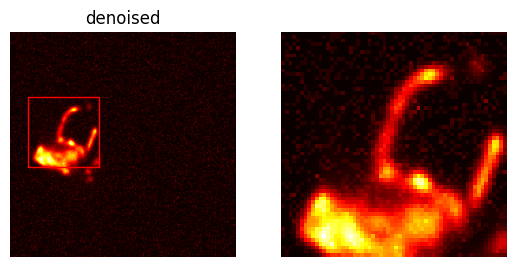

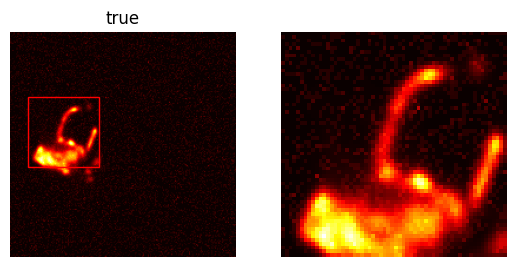

In [12]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

## 6. metrics evaluation

In [13]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

data range: 1.5071916580200195


/root/miniconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:123: RuntimeWarning: invalid value encountered in divide
  return squares_sum / ((filtered_values.shape))


calculate_metrics running: 48.889072271063924 second
PSNR: 71.88451561201559; SSIM: 0.9999237669002476; MAE: 0.17533078809356084; BRISQUE: 149.7815343472268


# Save denormalized denoised data into 16-bit DICOM files

restore_data: int16 shape:(24, 71, 192, 192); range:(-32768,32767); mean:-245.31539695711888; std:5771.306276448494


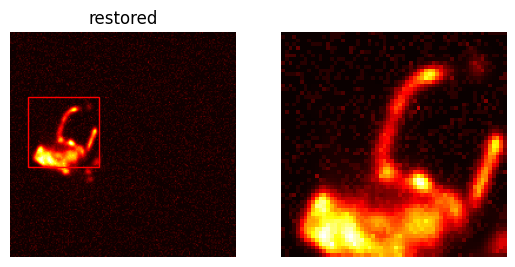

In [14]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored")

In [15]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/N2V/PT_20p 150_120 OSEM_poisson_0.35'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)

Processing time points: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]

Saved 1704 denoised DICOM files.
